<a href="https://www.kaggle.com/code/lucasfuller96/facial-feature-recognition?scriptVersionId=160301018" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


In [2]:
import matplotlib.pyplot as plt

# Load Data

In [3]:
training = pd.read_csv('/kaggle/input/facial-keypoints-detection/training.zip')
id_lookup_table = pd.read_csv('/kaggle/input/facial-keypoints-detection/IdLookupTable.csv')
test = pd.read_csv('/kaggle/input/facial-keypoints-detection/test.zip')
SampleSubmission = pd.read_csv('/kaggle/input/facial-keypoints-detection/SampleSubmission.csv')

In [4]:
# create image array
n_examples = training.shape[0]

train_image_flat = np.array([x.split() for x in training['Image'].values])
X_train = np.array(train_image_flat).astype(float).reshape(n_examples,96,96)

# standardise between 1 and 0
pixel_max = np.max(X_train)
X_train /= pixel_max

In [5]:
# split into feature names and values
feature_names = np.array([x.replace('_x','') for n,x in enumerate(training.columns) if n%2 == 0 and x != 'Image'])

y_train = training.drop(['Image'],axis=1).values

# convert features_values to 1 row per feature
n_features = int((y_train.shape[1])/2)

print(y_train.shape)
y_train = y_train.reshape(n_examples,n_features,2)

(7049, 30)


In [6]:
print(feature_names.shape) # 15 features
print(y_train.shape) # 7049 examples|15 features|2 x/y co-ordinates
print(X_train.shape) # 7049 examples|96 pixel width|96 pixel height

(15,)
(7049, 15, 2)
(7049, 96, 96)


# View example images with feature labels

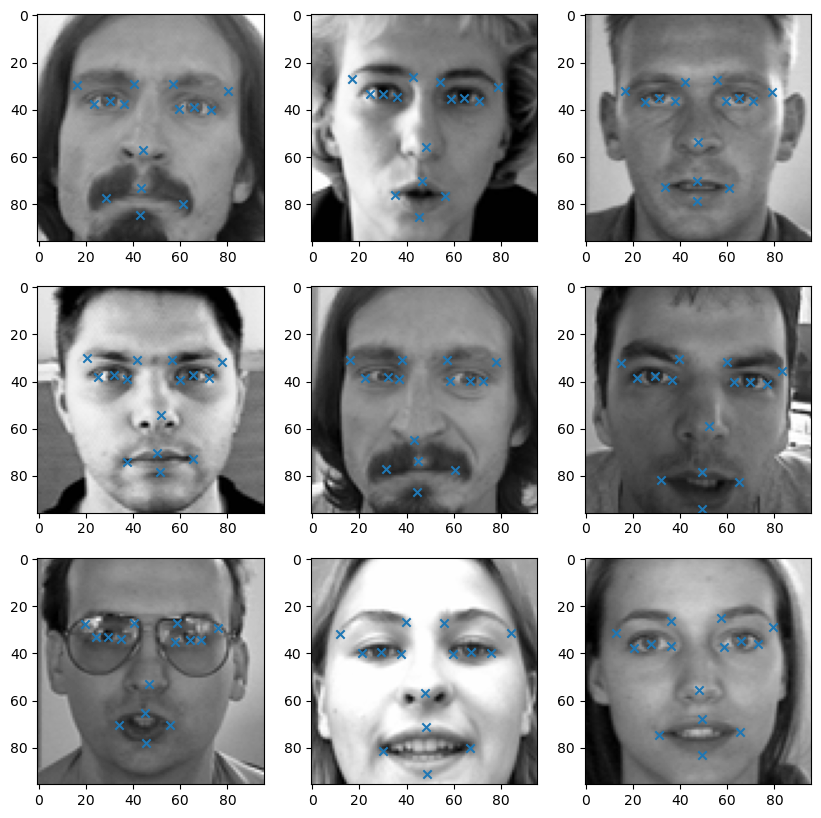

In [7]:
# view first 10 images
plt.figure(figsize=(10,10))

for n in range(9):
    plt.subplot(3,3,n+1)
    plt.imshow(X_train[n], cmap='gray')
    plt.scatter(y_train[n,:,0]
                ,y_train[n,:,1]
                ,marker='x')

plt.show()

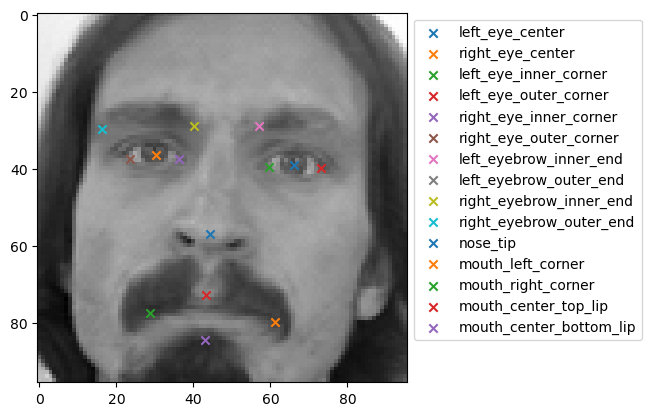

In [8]:
# view first exmaple with labels
plt.imshow(X_train[0], cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(y_train[0,n,0]
                ,y_train[0,n,1]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

# Approach 1.
## - Create a model that can classify an n x n images (centred on a feature location) as one of the 15 features 
## - Then scan through each of the n x n images throughout the original image and make classifications
## - take the image location with the maximum condifend for the 15 images, which will be the predicted image location

### Look at an example n x n image we can use in our training data

In [9]:
X_train_0 = X_train[0]
y_train_0 = y_train[0][0].astype(int)
feature_names_0 = feature_names[0]

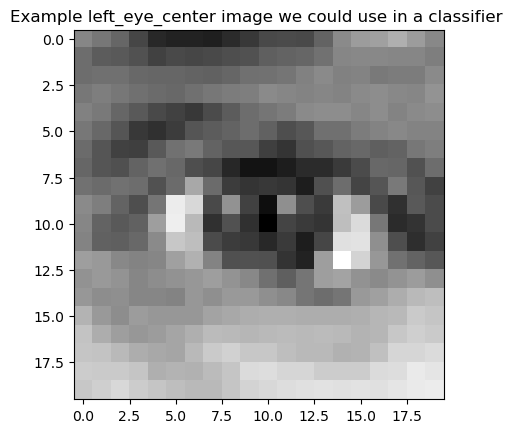

In [10]:
class_image_size = 10

plt.imshow(X_train_0[y_train_0[1]-class_image_size:y_train_0[1]+class_image_size
                        ,y_train_0[0]-class_image_size:y_train_0[0]+class_image_size]
          ,cmap='gray'
          )

plt.title(f'Example {feature_names_0} image we could use in a classifier ')

plt.show()

## Create test set of classification images
### First check for NULL values and feature locations outside of limits produced by a n x n image

In [11]:
# check no images have a nan value for just one of the pixel locations
n=0

for x in np.isnan(y_train):
    for y in x:
        if y[0] != y[1]:
            n += 1
print(f'There are {n} example with a null value for only one co-ordinate.')

There are 0 example with a null value for only one co-ordinate.


In [12]:
# half the examples are null, we'll just exclude them in this case
print('Half of the training examples are NULL')
print(pd.DataFrame(~np.isnan(y_train.reshape(-1))).value_counts())


Half of the training examples are NULL
True     106058
False    105412
dtype: int64


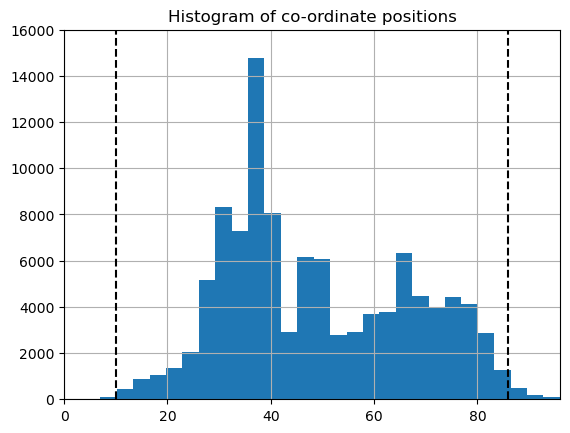

In [13]:
# print distribution of feature co-ordiates - anything < n and > 96- n will be excluded since it can't be centred on a n x n image
pd.DataFrame(y_train[~np.isnan(y_train)]).hist(bins=30)

plt.vlines(class_image_size, 0, 16000, color='black', linestyle='--')
plt.vlines(96 - class_image_size, 0, 16000, color='black', linestyle='--')

plt.ylim(0, 15000)
plt.yticks(np.arange(0,16001,2000))
plt.xlim(0, 96)

plt.title('Histogram of co-ordinate positions')
plt.show()

In [14]:
## create array corresponding to feature label
feature_index = np.arange(0,15,1, dtype=int)
feature_index = np.tile(feature_index, (len(y_train),1)).reshape(len(y_train), 15, 1)

In [15]:
# create array corresponding to image index
image_index = np.arange(0,7049,1, dtype=int)
image_index = np.tile(image_index, (15,1)).T.reshape(len(y_train), 15, 1)


In [16]:
print(y_train.shape)
print(feature_index.shape)
print(image_index.shape)

(7049, 15, 2)
(7049, 15, 1)
(7049, 15, 1)


In [17]:
# concatenate y_train with corresponding feature label and image index
y_train_index = np.concatenate((y_train, feature_index, image_index), axis=2)

In [18]:
print(y_train_index.shape)

(7049, 15, 4)


In [19]:
# remove nan values 
y_train_non_nans = y_train_index[~np.any(np.isnan(y_train_index), axis=2)]

In [20]:
# remove indexes that would result in feature images out of range
y_train_within_bounds = y_train_non_nans[~(np.any(((y_train_non_nans[:,0:2] < class_image_size + 1) | (y_train_non_nans[:,0:2] > 96 - (class_image_size + 1))), axis=1))]

In [21]:
print(y_train_index.reshape(-1, 4).shape)
print(y_train_non_nans.shape)
print(y_train_within_bounds.shape)

(105735, 4)
(53029, 4)
(51693, 4)


In [22]:
# view feature frequency in non-null dataset
Y_df_non_null = pd.DataFrame(y_train_non_nans[:,2].astype(int), columns=['Feature']).value_counts().rename('non_null').to_frame()
Y_df_within_bounds = pd.DataFrame(y_train_within_bounds[:,2].astype(int), columns=['Feature']).value_counts().rename('within_bounds').to_frame()
feature_names_df = pd.DataFrame(feature_names, columns=['Feature Name'])
feature_frequency = feature_names_df.merge(Y_df_non_null, left_index=True, right_on='Feature')
feature_frequency = feature_frequency.merge(Y_df_within_bounds, left_index=True, right_on='Feature')

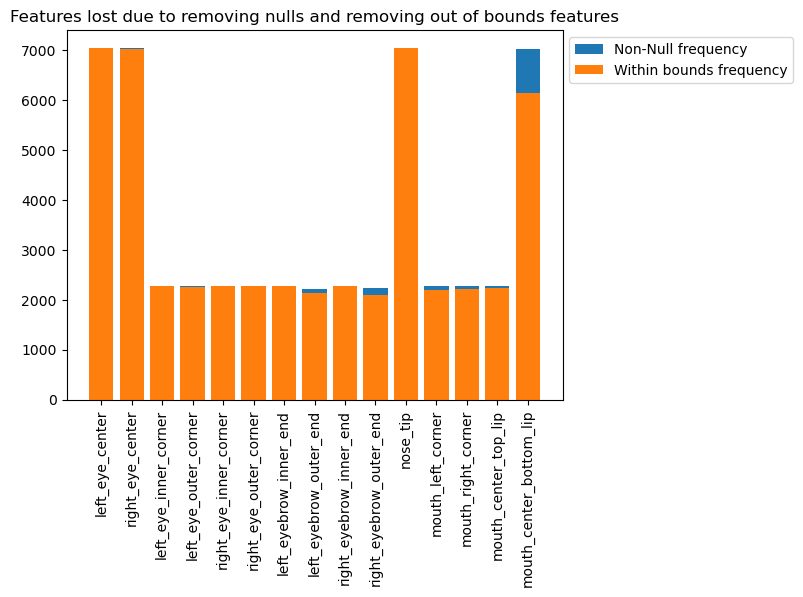

In [23]:
# we've lost a reasonable amount of the lower features (e.g. around the mouth), and the outer eyebrow features

plt.bar(feature_frequency['Feature Name'],feature_frequency['non_null'], label = 'Non-Null frequency')
plt.bar(feature_frequency['Feature Name'],feature_frequency['within_bounds'], label = 'Within bounds frequency')

plt.xticks(rotation=90)

plt.legend(bbox_to_anchor=(1,1))

plt.title('Features lost due to removing nulls and removing out of bounds features')
plt.show()

In [24]:
print(y_train_index.shape)
print(y_train_non_nans.shape)
print(y_train_within_bounds.shape)
print(y_train_within_bounds[:,0:2].max())
print(y_train_within_bounds[:,0:2].min())

(7049, 15, 4)
(53029, 4)
(51693, 4)
84.9883076923
11.0257701713


## Create image subsets

In [25]:
# process feature image subset for examples
X = np.zeros((len(y_train_within_bounds), 2*class_image_size, 2*class_image_size))  # no. examples | n by n image
Y = y_train_within_bounds[:,2].astype(int)

for n, data in enumerate(y_train_within_bounds):
    
    x = data[0].astype(int)
    y = data[1].astype(int)
    i = data[3].astype(int)
    
    X[n] = X_train[i][y-class_image_size:y+class_image_size
                              ,x-class_image_size:x+class_image_size]
        
        
    

In [26]:
# check we've got correct sized images
X[0].shape

(20, 20)

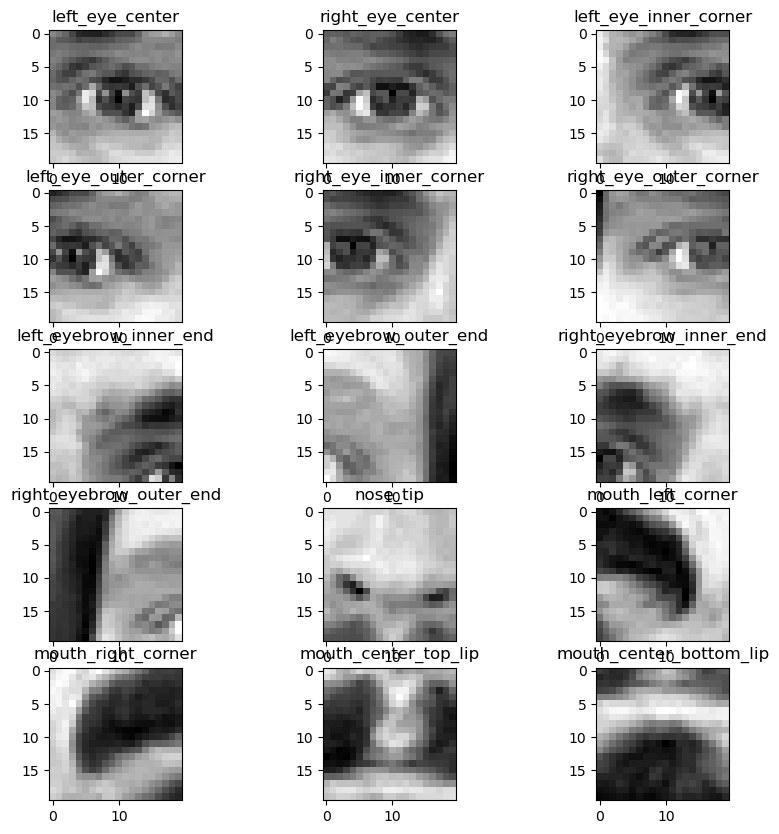

In [27]:
# view first 10 images
plt.figure(figsize=(10,10))

for n in range(15):
    plt.subplot(5,3,n+1)
    plt.imshow(X[n], cmap='gray')
    plt.title(feature_names[Y[n]])

plt.show()

# Build Data Loader


In [28]:
import torch
import torch.nn as nn

In [29]:
X_torch = torch.tensor(X, dtype=torch.float32).view([len(X), 1, 2*class_image_size, 2*class_image_size])
Y_torch = torch.tensor(Y, dtype=torch.int64)

In [30]:
from sklearn.model_selection import train_test_split

X_train_torch, X_test_torch, y_train_torch, y_test_torch = train_test_split(X_torch, Y_torch, test_size=0.2, random_state=4)
 

In [31]:
train_loader = torch.utils.data.DataLoader(dataset=list(zip(X_train_torch,y_train_torch)), batch_size=50)
test_loader = torch.utils.data.DataLoader(dataset=list(zip(X_test_torch,y_test_torch)), batch_size=50)

# Define Model Class

In [32]:
class CNN(nn.Module):
    
    # constructor
    def __init__(self, input_size
                     , out_1=4, cn1_kernal_size=3
                     , out_2=4, cn2_kernal_size=3
                     , out_3=4, cn3_kernal_size=5
                     , out_4=4, cn4_kernal_size=5
                     , out_5=4, cn5_kernal_size=5
                     , output_size=15):
        
        super().__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=cn1_kernal_size, padding='same')
        #self.maxpool1 = nn.MaxPool2d(kernel_size=mp1_kernal_size)
        self.output1size = int(input_size)
        self.batchnorm1 = nn.BatchNorm2d(out_1)
        
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=cn2_kernal_size, padding='same') 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.output2size = int((self.output1size)/2)
        self.batchnorm2 = nn.BatchNorm2d(out_2)
        
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=cn3_kernal_size, padding='same')
        #self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.output3size = int((self.output2size))
        self.batchnorm3 = nn.BatchNorm2d(out_3)        
        
        
        self.cnn4 = nn.Conv2d(in_channels=out_3, out_channels=out_4, kernel_size=cn4_kernal_size, padding='same')
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.output4size = int(self.output3size/2)
        self.batchnorm4 = nn.BatchNorm2d(out_4)   
     
        
        self.cnn5 = nn.Conv2d(in_channels=out_4, out_channels=out_5, kernel_size=cn5_kernal_size, padding='same')
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)
        self.output5size = int(self.output4size/2)
        self.batchnorm5 = nn.BatchNorm2d(out_5)  
        
        
        #self.dropout = nn.Dropout(0.2)
        #self.linear1 = nn.Linear(int(out_2 * self.output2size * self.output2size), 250)

        self.linear1 = nn.Linear(int(out_5 * self.output5size * self.output5size), 500)
        self.linear2 = nn.Linear(500, output_size)
        
    def forward(self, x):
        
        x = self.cnn1(x)
        x = torch.relu(x)
        #x = self.maxpool1(x)
        x = self.batchnorm1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.batchnorm2(x)
        
        x = self.cnn3(x)
        x = torch.relu(x)
        #x = self.maxpool3(x)
        x = self.batchnorm3(x)
        
         
        x = self.cnn4(x)
        x = torch.relu(x)
        x = self.maxpool4(x)
        x = self.batchnorm4(x)
    
         
        x = self.cnn5(x)
        x = torch.relu(x)
        x = self.maxpool5(x)
        x = self.batchnorm5(x)
        
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.softmax(x,1)
        
        return x

# Create function to train model and store metrics

In [33]:
def train_model(n_epochs):
    
    error = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(n_epochs):
        
        for x, y in train_loader:
            
            y_pred = cnn(x)
            
            optimizer.zero_grad()
            
            loss = criterion(y_pred, y)
            
            loss.backward()
            
            optimizer.step()
        
        
        # log error
        error.append(loss.item())
        
        # log train accuracy
        train_pred = torch.argmax(cnn(X_train_torch), axis =1)
        
        train_accuracy.append(100 * torch.sum(train_pred == y_train_torch)/y_train_torch.shape[0])
        
        # log test accuracy
        test_pred = torch.argmax(cnn(X_test_torch), axis =1)
        
        test_accuracy.append(100 * torch.sum(test_pred == y_test_torch)/y_test_torch.shape[0])
        
        
        print(f'Ran epoch {epoch+1}')
        
    return error, train_accuracy, test_accuracy


# Add weights to classes 
### - Otherwise can get stuck classifying everything as the most common labels


In [34]:
from sklearn.utils.class_weight import compute_class_weight

loss_feature_weight = torch.tensor(compute_class_weight(class_weight ='balanced', classes= np.unique(Y_torch),  y = Y_torch.numpy())).float()

# Define Model Architecture for the 5 Convolutional Layers
### - Start with a smaller Kernal size and fewer kernals to learn low level features, e.g. lines
### - Increase kernal size and number of them to progressivally to learn higher level abstractions

In [35]:
input_size = 2* class_image_size

out_1 = 8
cn1_kernal_size = 3

out_2 = 32
cn2_kernal_size = 5

out_3 = 64
cn3_kernal_size = 5          


out_4 = 128
cn4_kernal_size = 7          


out_5 = 128
cn5_kernal_size = 7   

output_size = len(feature_names)


cnn = CNN(input_size=input_size
          ,out_1=out_1
          ,cn1_kernal_size=cn1_kernal_size
          ,out_2=out_2
          ,cn2_kernal_size=cn2_kernal_size
          ,out_3=out_3
          ,cn3_kernal_size=cn3_kernal_size
          ,out_4=out_4
          ,cn4_kernal_size=cn4_kernal_size
          ,out_5=out_5
          ,cn5_kernal_size=cn5_kernal_size
          ,output_size = output_size
         )

learning_rate = 0.1

criterion  = nn.CrossEntropyLoss(weight=loss_feature_weight)
optimizer = torch.optim.SGD(cnn.parameters(), lr = learning_rate)
loss, train_accuracy, test_accuracy = train_model(20)

Ran epoch 1
Ran epoch 2
Ran epoch 3
Ran epoch 4
Ran epoch 5
Ran epoch 6
Ran epoch 7
Ran epoch 8
Ran epoch 9
Ran epoch 10
Ran epoch 11
Ran epoch 12
Ran epoch 13
Ran epoch 14
Ran epoch 15
Ran epoch 16
Ran epoch 17
Ran epoch 18
Ran epoch 19
Ran epoch 20


# View Loss and Test/Train Accuracy by epoch

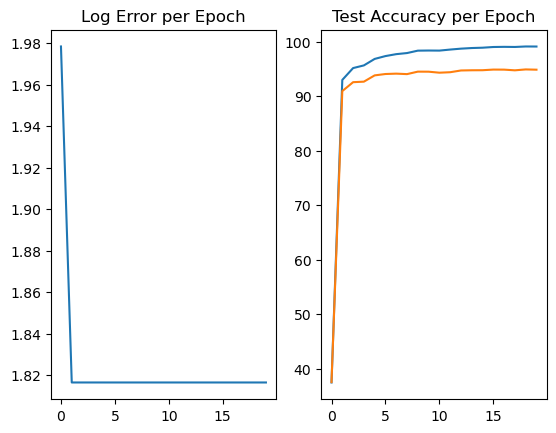

In [36]:
print()
plt.subplot(1,2,1)
plt.plot(loss)
plt.title('Log Error per Epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracy, label='Test Accuracy')
plt.plot(test_accuracy, label='Train Accuracy')
plt.title('Test Accuracy per Epoch')

plt.show()

# Check Accuracy across classes
## - Want to check that we're not just seeing high accuracy across several classes, and no predictions on others

In [37]:
y_pred = torch.argmax(cnn(X_test_torch), axis =1)

In [38]:
feature_occurance = pd.DataFrame(y_test_torch,columns=['Feature']).value_counts().rename('feature_occurance').to_frame()
prediction_occurance = pd.DataFrame(y_pred,columns=['Feature']).value_counts().rename('prediction_occurance').to_frame()


feature_occurance = feature_names_df.merge(feature_occurance, right_on='Feature', left_index=True, how='left').loc[:,['Feature Name','feature_occurance']]
prediction_occurance = feature_names_df.merge(prediction_occurance, right_on='Feature', left_index=True, how='left').loc[:,['Feature Name','prediction_occurance']].fillna(0)


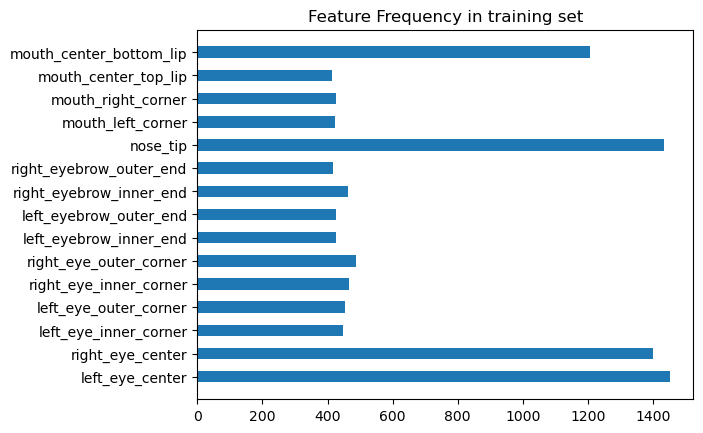

In [39]:
plt.barh(feature_occurance['Feature Name'],feature_occurance['feature_occurance'], height=0.5)
plt.title('Feature Frequency in training set')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

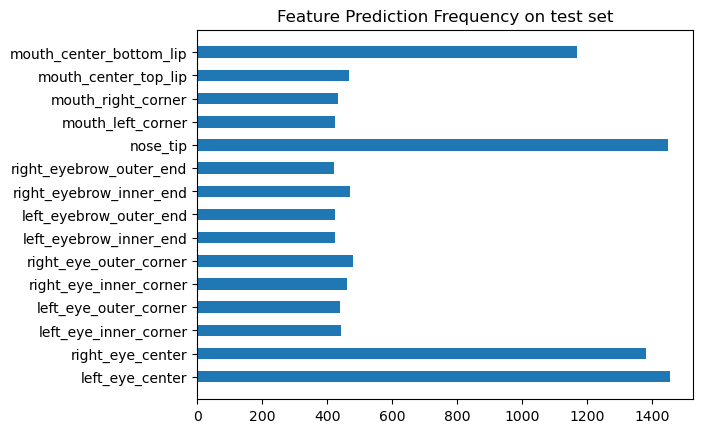

In [40]:
plt.barh(prediction_occurance['Feature Name'],prediction_occurance['prediction_occurance'], height=0.5)
plt.title('Feature Prediction Frequency on test set')

plt.show

In [41]:
class_accuracy = []
for n in range(15):
    
    n_index = y_test_torch == n
    
    y_test_true = y_test_torch[n_index]
    y_test_pred = torch.argmax(cnn(X_test_torch[n_index]), axis =1)
    
    class_accuracy.append(100 * torch.sum(y_test_pred == y_test_true)/y_test_true.shape[0])
    

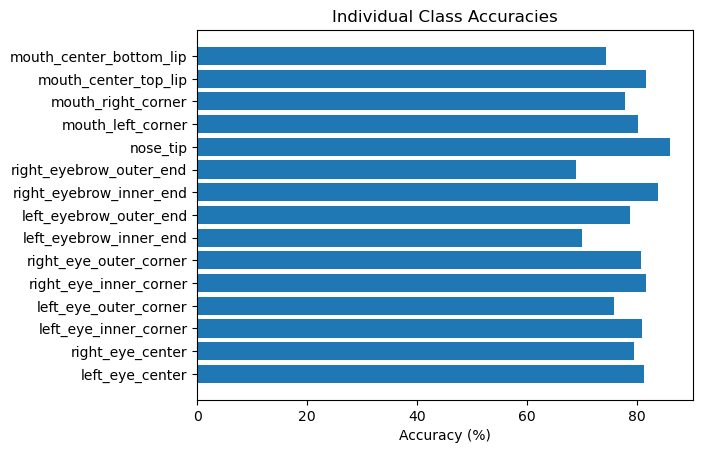

In [42]:
plt.barh(feature_names, class_accuracy)
plt.title('Individual Class Accuracies')
plt.xlabel('Accuracy (%)')

plt.show()

# Plot predictions on first image

In [43]:
X_train_0.shape

image_class_predictions = torch.zeros([96-(2*class_image_size-1), 96-(2*class_image_size-1), 15])

for row in range(96-(2*class_image_size-1)):
    
    for column in range(96-(2*class_image_size-1)):
        
        image_subset = torch.tensor(X_train_0[row:row+ (2 * class_image_size), column:column+(2 * class_image_size)], dtype=torch.float32).view([1, 1, 2*class_image_size, 2*class_image_size])
        
        subset_predictions = cnn(image_subset)
        
        image_class_predictions[row, column, :] = subset_predictions

In [44]:
##get position for each feature
predicted_index = np.zeros([15])

for n in range(15):
    
    predicted_index[n] = torch.argmax(image_class_predictions[:, :, n])
    


In [45]:
# convert index
image_sample_size = image_class_predictions.shape[0]

original_index = np.stack((predicted_index % image_sample_size ## column (x)
                            ,predicted_index // image_sample_size)) ## row (y)

converted_index = np.stack(((class_image_size-1) + predicted_index % image_sample_size ## column (x)
                            ,(class_image_size-1) + predicted_index // image_sample_size)) ## row (y)

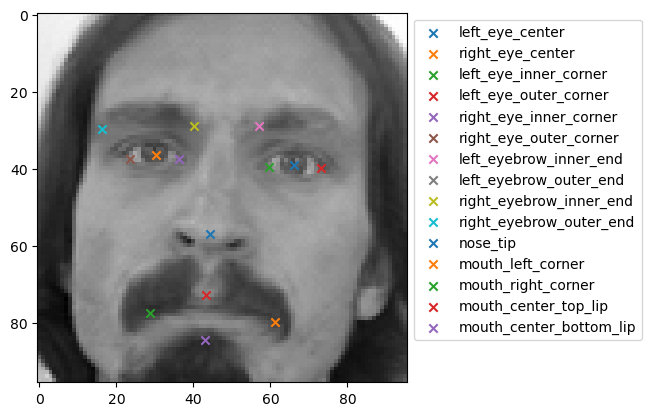

In [46]:
# view first exmaple with labels
plt.imshow(X_train[0], cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(y_train[0,n,0]
                ,y_train[0,n,1]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))


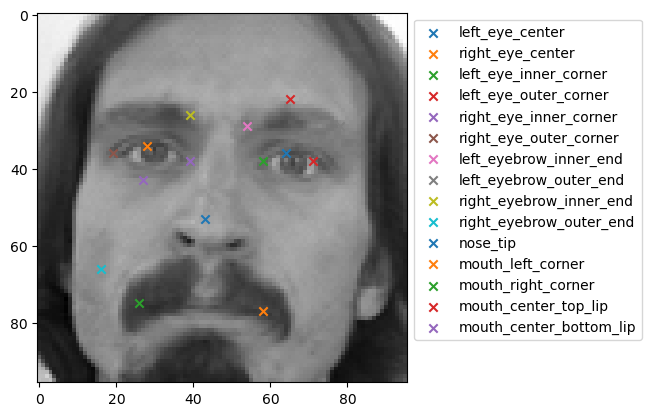

In [47]:
plt.imshow(X_train_0, cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(converted_index[0,n]
                ,converted_index[1,n]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))

# Looks at image heat maps

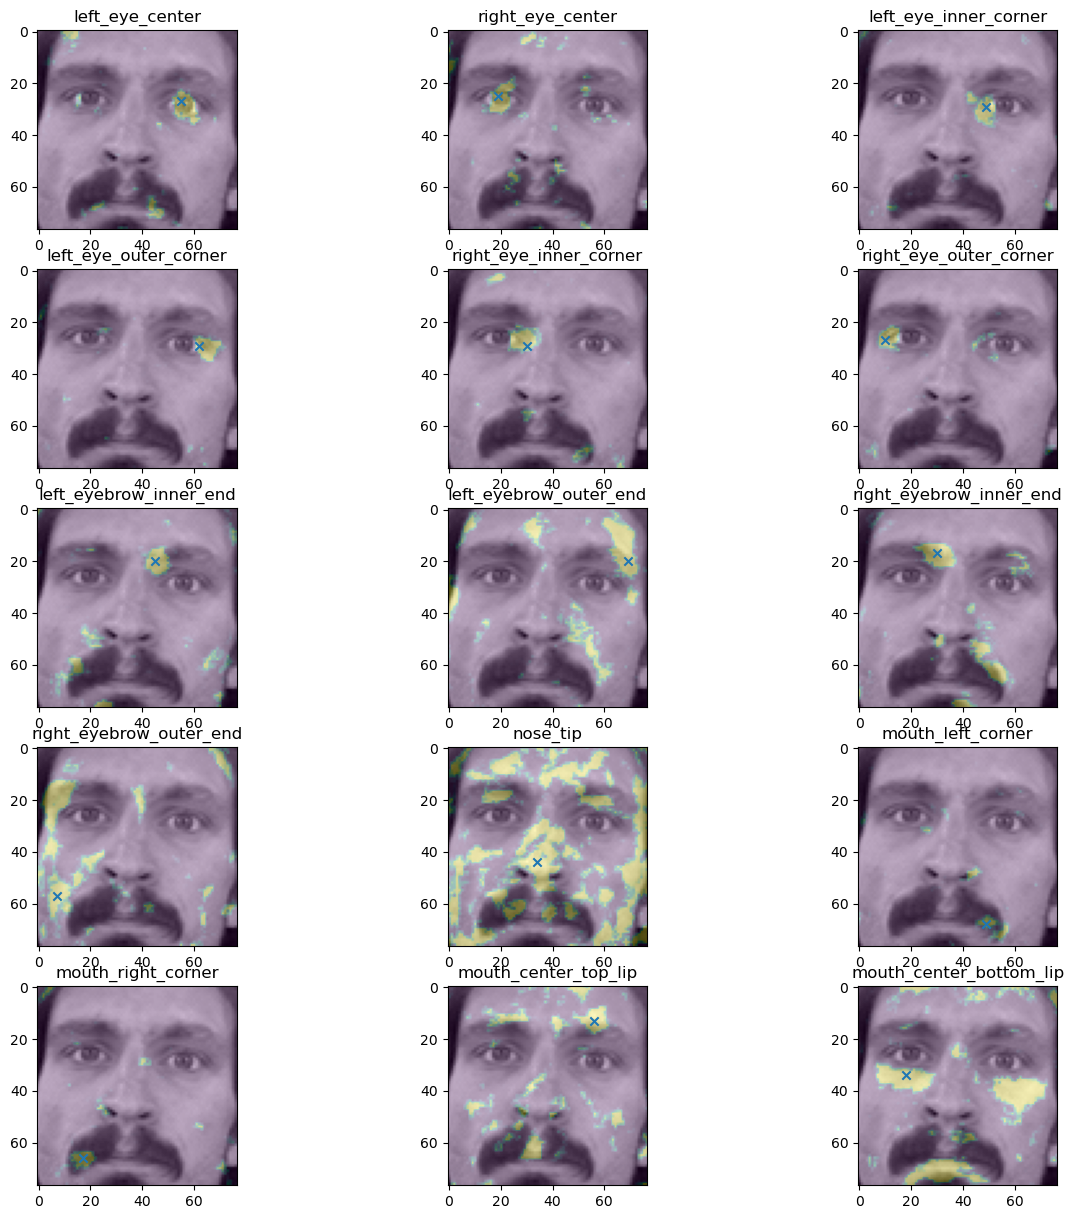

In [48]:

plt.figure(figsize=(15,15))

for n, name in enumerate(feature_names):
    
    plt.subplot(5, 3, n+1)
    
    plt.imshow(X_train_0[class_image_size:96-(class_image_size-1),class_image_size:96-(class_image_size-1)], cmap='gray')
    plt.imshow(image_class_predictions[:, : , n].detach(), alpha=0.3)
    
    plt.scatter(original_index[0,n]
                ,original_index[1,n]
                ,marker='x')
    plt.title(name)


# Notes on Approach 1.
## - Seems to be good at predicting certain features on the whole image, but the heatmaps show that it struggles with others
## - e.g. nose performed well on the purely classification task, but didn't generalise well to the whole images
## - I've experimented with larger architectures, but it still has the same issue
## - Hypothesis is that the model doesn't know how to deal with the areas of the images that not any class, e.g. the cheeks
## - This could be rectified by adding an additional class that is images not belonging to any of the classes



# Approach 2.
## - A better approach might just be to create a model that predicts the co-ordinates directly.
## - In this case the model inherently gets to see parts of the face that don't belong to any features
## - Try predicting co-ordinates from image instead (i.e. have 30 outputs that correspond to the pixel location)
## - We can re-use the same architecture, but set the number of output classes to 30 (for the 15 x and y co-ordinates)

## Re-examine the NULLS in our Y_train dataset

In [49]:
## reshape to have 30 outputs
y_train = y_train.reshape(y_train.shape[0], 30)
print(y_train.shape)

(7049, 30)


In [50]:
# view size of dataset where an image has all co-ordinates for the 15 images
print(y_train[~np.any(np.isnan(y_train), axis=1)].shape)

print('If we just ignore the NULLs we lose over 2/3 of out dataset - we should deal with them for this approach!')

(2140, 30)
If we just ignore the NULLs we lose over 2/3 of out dataset - we should deal with them for this approach!


# Impute values with mean position of non-null features
### - These won't be perfect, but should be reasonbaly close!

In [51]:
# The last sample has a lot of nulls so we can use this to figure out how well this works
print(y_train[-1])

[66.93831111 43.42450963 31.09605926 39.52860444         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan 47.06925037 73.03333926         nan         nan
         nan         nan         nan         nan 45.90048    82.7730963 ]


In [52]:
coord_means = np.nanmean(y_train, axis=0)

In [53]:
y_train_fill_na = y_train.copy()

for n in range(30):
    
    y_train_fill_na[:,n] = np.nan_to_num(y_train_fill_na[:,n], nan=coord_means[n])

In [54]:
# The last sample has a lot of nulls so we can use this to figure out how well this works
print(y_train_fill_na[-1])

[66.93831111 43.42450963 31.09605926 39.52860444 59.15933944 37.94475233
 73.33047798 37.70700831 36.65260695 37.98990191 22.38450448 38.03349518
 56.06851308 29.33267825 79.48282586 29.73486073 39.32213692 29.50299847
 15.87117747 30.42816591 47.06925037 73.03333926 63.28573512 75.97071434
 32.9004037  76.17976785 47.97541157 72.9194426  45.90048    82.7730963 ]


In [55]:
y_train = y_train_fill_na

# View the above example
### - Not perfect, but pretty close! Let's see how accuracy we can get with this.

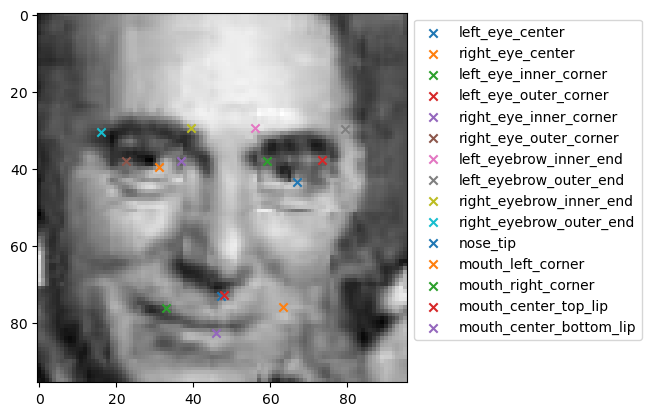

In [56]:
# view first exmaple with labels
plt.imshow(X_train[-1], cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(y_train_fill_na.reshape(y_train_fill_na.shape[0], 15, 2)[-1,n,0]
                ,y_train_fill_na.reshape(y_train_fill_na.shape[0], 15, 2)[-1,n,1]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

# Add perturbations to images 
### - 1. Rotation
### - 2. Translation
### - 3. Random Noise

## 1. Rotation
#### - Create a version of each imgage rotated at a random angle between -30 and 30 degrees

In [57]:
rotation_angle = np.random.randint(-30, 30, (len(X_train)))

In [58]:
from PIL import Image

X_train_rotation = np.zeros(X_train.shape)
y_train_rotation = np.zeros(y_train.shape)


for n, image in enumerate(X_train):
    
    theta = rotation_angle[n]
    
    # rotation image
    X_Image = Image.fromarray(np.uint8(image*pixel_max))
        
    X_Image = X_Image.rotate(theta)
    
    X_train_rotation[n] = np.array(X_Image)/pixel_max
    
    # rotate co-ordinates 
    rad = theta * (np.pi/180)
    
    cx = int(96 / 2)
    cy = int(96 / 2)
    
    for y in range(15):
        
        px = y_train[n,2*y]
        py = y_train[n,2*y+1]

        y_train_rotation[n,2*y] = cx + int(float(px-cx) * np.cos(rad) + float(py-cy) * np.sin(rad))       
       
        y_train_rotation[n,2*y+1] = cy + int(-(float(px-cx) * np.sin(rad)) + float(py-cy) * np.cos(rad))
    
    

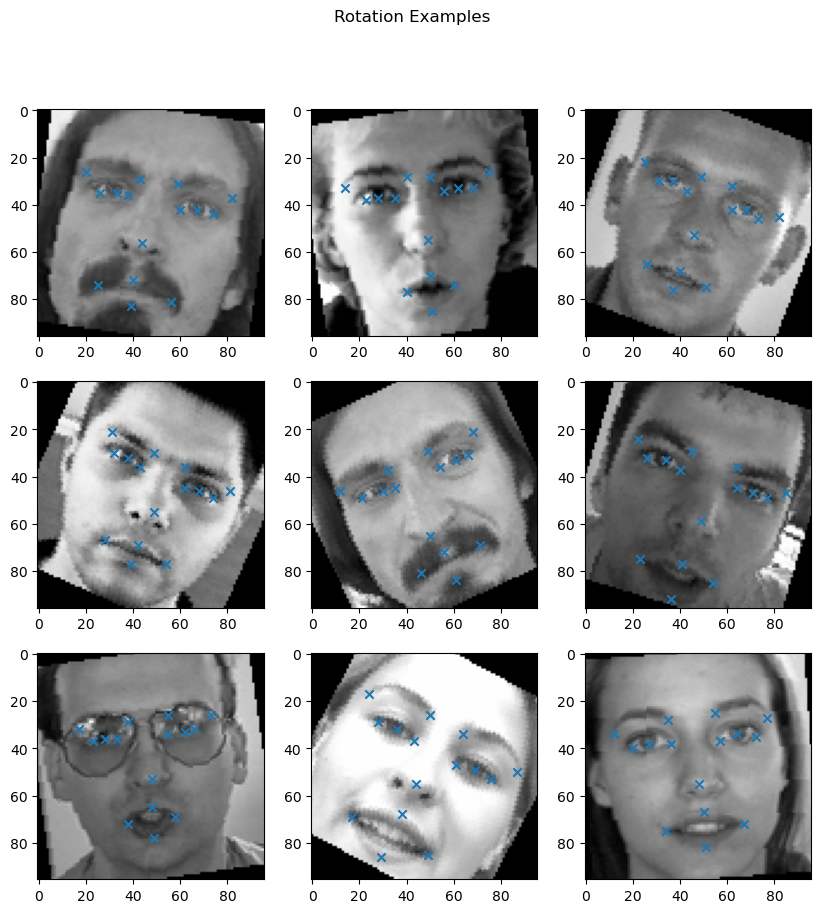

In [59]:
# view first 10 images
plt.figure(figsize=(10,10))

for n in range(9):
    plt.subplot(3,3,n+1)
    plt.imshow(X_train_rotation[n], cmap='gray')
    plt.scatter(y_train_rotation.reshape(len(y_train_rotation),15,2)[n,:,0]
                ,y_train_rotation.reshape(len(y_train_rotation),15,2)[n,:,1]
                ,marker='x')
    
plt.suptitle('Rotation Examples')

plt.show()

## 2. Translation
### - Translate each image between 0 and 8 co-ordinates in a random direction
### - only move up since we have a lot of features right at the bottom of some images

In [60]:
translations = np.random.randint(1, 8, (len(X_train), 2))


In [61]:
X_train_translate = np.zeros(X_train.shape)
y_train_translate = np.zeros(y_train.shape)


for n, image in enumerate(X_train):
    
    t_x = translations[n,0]
    t_y = translations[n,1]
    
    # translate image
    X_train_translate[n, :-t_x, :-t_y] = image[t_x:, t_y:]
    
    # translate co-ordinates
    for y in range(15):

        y_train_translate[n,2*y] = y_train[n,2*y] - t_x
       
        y_train_translate[n,2*y+1] = y_train[n,2*y+1] - t_y
    
    

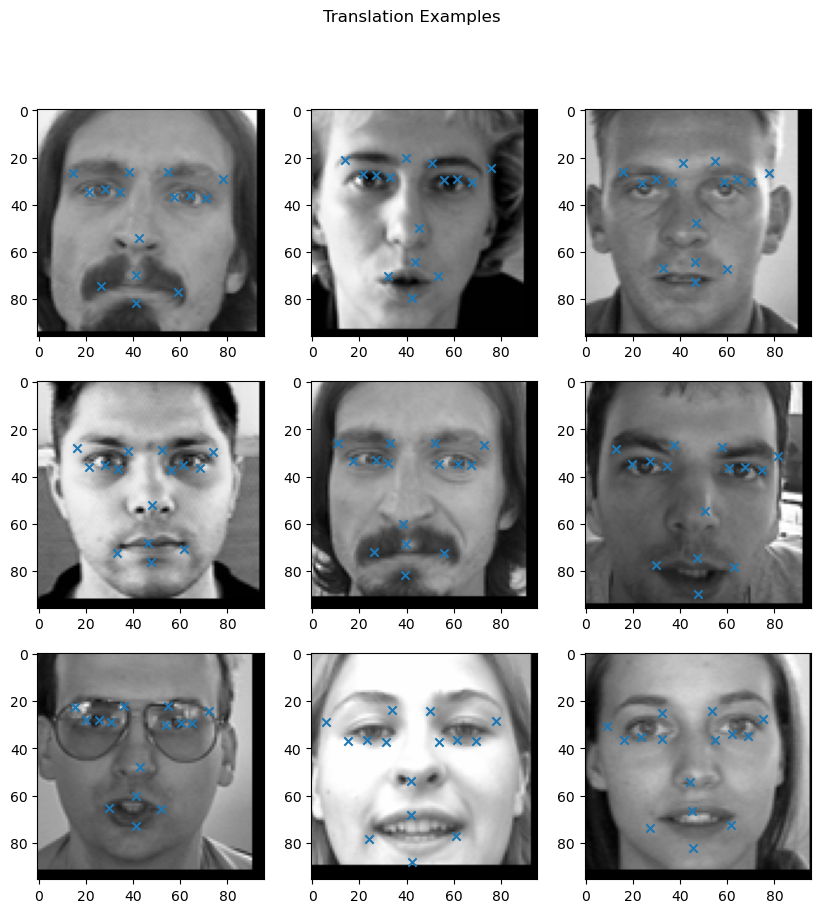

In [62]:
# view first 10 images
plt.figure(figsize=(10,10))

for n in range(9):
    plt.subplot(3,3,n+1)
    plt.imshow(X_train_translate[n], cmap='gray')
    plt.scatter(y_train_translate.reshape(len(y_train_translate),15,2)[n,:,0]
                ,y_train_translate.reshape(len(y_train_translate),15,2)[n,:,1]
                ,marker='x')
plt.suptitle('Translation Examples')

plt.show()

# 3. Random Noise
### - Add random noise to images

In [63]:
noise = np.random.random(X_train.shape)/10

X_train_noise = X_train + noise


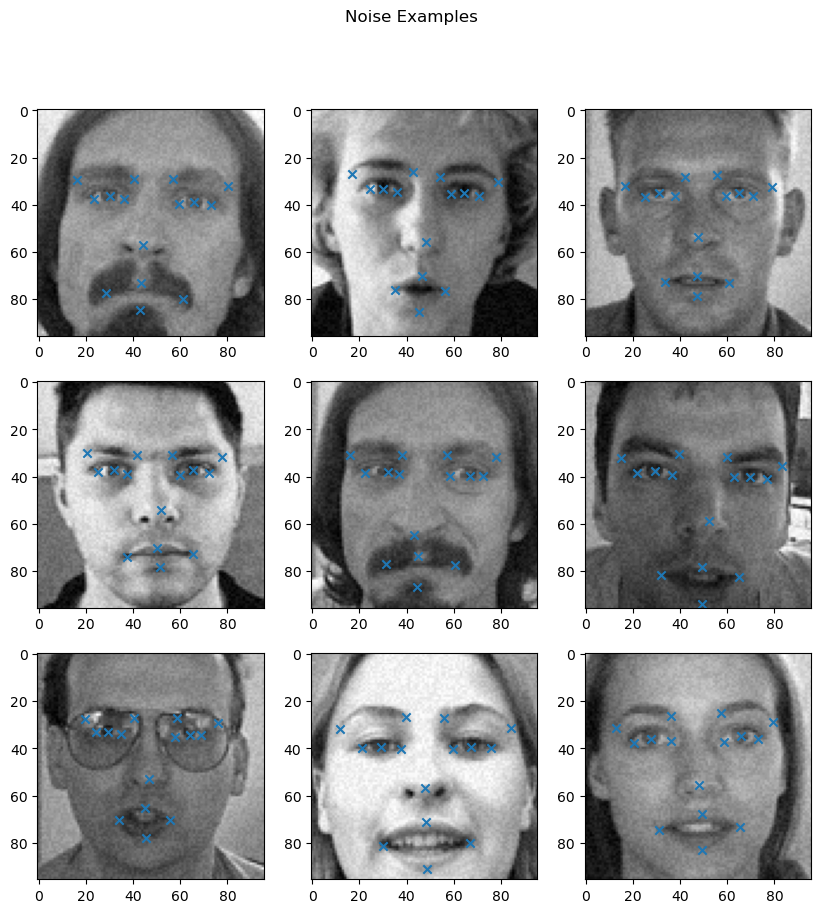

In [64]:
# view first 10 images
plt.figure(figsize=(10,10))

for n in range(9):
    plt.subplot(3,3,n+1)
    plt.imshow(X_train_noise[n], cmap='gray')
    plt.scatter(y_train.reshape(len(y_train),15,2)[n,:,0]
                ,y_train.reshape(len(y_train),15,2)[n,:,1]
                ,marker='x')

plt.suptitle('Noise Examples')

plt.show()

# Join new datasets onto master dataset
### - First remove any new examples that migt now have features outside the 96x96 grid from rotation and translation examples

In [65]:
X_train_translate = X_train_translate[~(np.any(((y_train_translate < 0) | (y_train_translate > 96)), axis=1))]
X_train_rotation = X_train_rotation[~(np.any(((y_train_rotation < 0) | (y_train_rotation > 96)), axis=1))]

y_train_translate = y_train_translate[~(np.any(((y_train_translate < 0) | (y_train_translate > 96)), axis=1))]
y_train_rotation = y_train_rotation[~(np.any(((y_train_rotation < 0) | (y_train_rotation > 96)), axis=1))]

In [66]:
X = np.vstack((X_train, X_train_rotation, X_train_translate, X_train_noise))
Y = np.vstack((y_train, y_train_rotation, y_train_translate, y_train))

In [67]:
X_train_rotation = []
X_train_translate = []
X_train_noise = []
y_train_rotation = []
y_train_translate = []
y_train = []


In [68]:
print(f'We now have {len(X)} samples.')

We now have 28181 samples.


# Create new DataLoader

In [69]:
X_torch = torch.tensor(X, dtype=torch.float32).view([len(X), 1, 96, 96])
Y_torch = torch.tensor(Y, dtype=torch.float32)

In [70]:
X_train_torch, X_test_torch, y_train_torch, y_test_torch = train_test_split(X_torch, Y_torch, test_size=0.2, random_state=4)

In [71]:
batch_size = 200
train_loader = torch.utils.data.DataLoader(dataset=list(zip(X_train_torch,y_train_torch)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=list(zip(X_test_torch,y_test_torch)), batch_size=batch_size, shuffle=True)

# Define Model Architecture size and train!
## - We've just re-used the kernal size and number from the previous approach, but set the output_size to 30 for the 30 co-ordinates
## - Also need to remove the softmax

In [72]:
class CNN(nn.Module):
    
    # constructor
    def __init__(self, input_size
                     , out_1=4, cn1_kernal_size=3
                     , out_2=4, cn2_kernal_size=3
                     , out_3=4, cn3_kernal_size=5
                     , out_4=4, cn4_kernal_size=5
                     , out_5=4, cn5_kernal_size=5
                     , output_size=15):
        
        super().__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=cn1_kernal_size, padding='same')
        #self.maxpool1 = nn.MaxPool2d(kernel_size=mp1_kernal_size)
        self.output1size = int(input_size)
        self.batchnorm1 = nn.BatchNorm2d(out_1)
        
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=cn2_kernal_size, padding='same') 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.output2size = int((self.output1size)/2)
        self.batchnorm2 = nn.BatchNorm2d(out_2)
        
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=cn3_kernal_size, padding='same')
        #self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.output3size = int((self.output2size))
        self.batchnorm3 = nn.BatchNorm2d(out_3)        
        
        
        self.cnn4 = nn.Conv2d(in_channels=out_3, out_channels=out_4, kernel_size=cn4_kernal_size, padding='same')
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.output4size = int(self.output3size/2)
        self.batchnorm4 = nn.BatchNorm2d(out_4)   
     
        
        self.cnn5 = nn.Conv2d(in_channels=out_4, out_channels=out_5, kernel_size=cn5_kernal_size, padding='same')
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)
        self.output5size = int(self.output4size/2)
        self.batchnorm5 = nn.BatchNorm2d(out_5)  
        
        
        #self.dropout = nn.Dropout(0.2)
        #self.linear1 = nn.Linear(int(out_2 * self.output2size * self.output2size), 250)

        self.linear1 = nn.Linear(int(out_5 * self.output5size * self.output5size), 500)
        self.linear2 = nn.Linear(500, output_size)
        
    def forward(self, x):
        
        x = self.cnn1(x)
        x = torch.relu(x)
        #x = self.maxpool1(x)
        x = self.batchnorm1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.batchnorm2(x)
        
        x = self.cnn3(x)
        x = torch.relu(x)
        #x = self.maxpool3(x)
        x = self.batchnorm3(x)
        
         
        x = self.cnn4(x)
        x = torch.relu(x)
        x = self.maxpool4(x)
        x = self.batchnorm4(x)
    
         
        x = self.cnn5(x)
        x = torch.relu(x)
        x = self.maxpool5(x)
        x = self.batchnorm5(x)
        
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x

In [73]:
def train_model(n_epochs):
    
    error = []
    train_mse = []
    test_mse = []

    for epoch in range(n_epochs):
        
        cnn.train()
        
        for x, y in train_loader:
            
            y_pred = cnn(x)
            
            optimizer.zero_grad()
            
            loss = criterion(y_pred, y)
            
            loss.backward()
            
            optimizer.step()
        
        
        # log error
        error.append(loss.item())
        
        cnn.eval()
        
        # log train accuracy
        
        train_pred = torch.zeros(y_train_torch.shape)

        for n, (x, y) in enumerate(train_loader):
    
            pred = cnn(x)
    
            train_pred[n*batch_size:n*batch_size+batch_size] = pred.detach()
        
        train_mse.append(torch.mean((train_pred - y_train_torch)**2).detach().numpy())
        
        # log test accuracy
        test_pred = torch.zeros(y_test_torch.shape)

        for n, (x, y) in enumerate(test_loader):
    
            pred = cnn(x)
    
            test_pred[n*batch_size:n*batch_size+batch_size] = pred.detach()
        
        test_mse.append(torch.mean((test_pred - y_test_torch)**2).detach().numpy())
            

        print(f'Ran epoch {epoch+1}')
    
    return error, train_mse, test_mse


In [74]:
input_size = 96 

out_1 = 8
cn1_kernal_size = 3

out_2 = 32
cn2_kernal_size = 5

out_3 = 32
cn3_kernal_size = 5          


out_4 = 64
cn4_kernal_size = 7          


out_5 = 128
cn5_kernal_size = 7   

output_size = 30


cnn = CNN(input_size=input_size
          ,out_1=out_1
          ,cn1_kernal_size=cn1_kernal_size
          ,out_2=out_2
          ,cn2_kernal_size=cn2_kernal_size
          ,out_3=out_3
          ,cn3_kernal_size=cn3_kernal_size
          ,out_4=out_4
          ,cn4_kernal_size=cn4_kernal_size
          ,out_5=out_5
          ,cn5_kernal_size=cn5_kernal_size
          ,output_size = output_size
         )

learning_rate = 0.001

criterion  = nn.MSELoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr = learning_rate)
loss, train_mse, test_mse = train_model(25)

Ran epoch 1
Ran epoch 2
Ran epoch 3
Ran epoch 4
Ran epoch 5
Ran epoch 6
Ran epoch 7
Ran epoch 8
Ran epoch 9
Ran epoch 10
Ran epoch 11
Ran epoch 12
Ran epoch 13
Ran epoch 14
Ran epoch 15
Ran epoch 16
Ran epoch 17
Ran epoch 18
Ran epoch 19
Ran epoch 20
Ran epoch 21
Ran epoch 22
Ran epoch 23
Ran epoch 24
Ran epoch 25


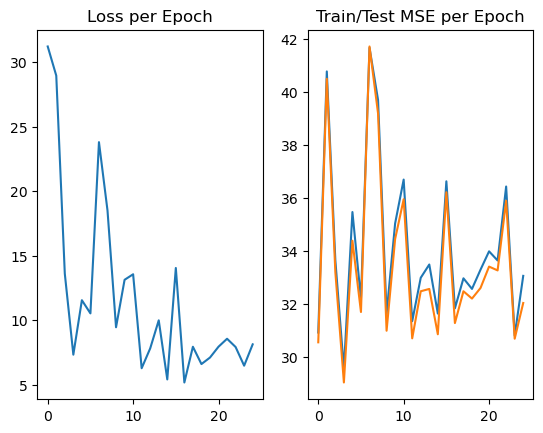

In [75]:
print()
plt.subplot(1,2,1)
plt.plot(loss)
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(train_mse, label='Train MSE')
plt.plot(test_mse, label='Test MSE')
plt.title('Train/Test MSE per Epoch')

plt.show()

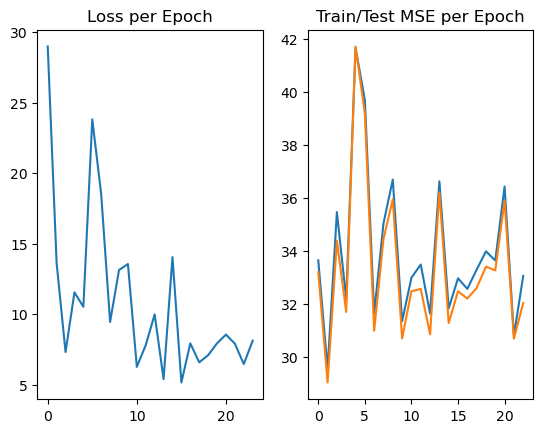

In [76]:
print()
plt.subplot(1,2,1)
plt.plot(loss[1:])
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(train_mse[2:], label='Train MSE')
plt.plot(test_mse[2:], label='Test MSE')
plt.title('Train/Test MSE per Epoch')

plt.show()

# Look at accuracy by facial feature

In [77]:
test_pred = torch.zeros(y_test_torch.shape)

# set model to evalutaion mode
cnn.eval()

for n, (x, y) in enumerate(test_loader):
            
            pred = cnn(x)
    
            size = pred.shape[0]
        
            test_pred[n*batch_size:n*batch_size+size] = pred.detach()

In [78]:
mse_by_feature = ((test_pred - y_test_torch) ** 2).mean(axis=0)

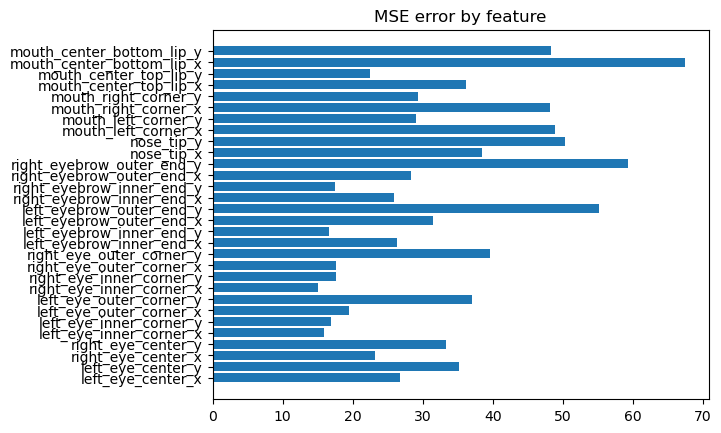

In [79]:
raw_fearure_names = training.columns[0:-1]

plt.barh(raw_fearure_names, mse_by_feature.numpy().reshape(-1))

plt.title('MSE error by feature')

plt.show()

# View a few example predictions

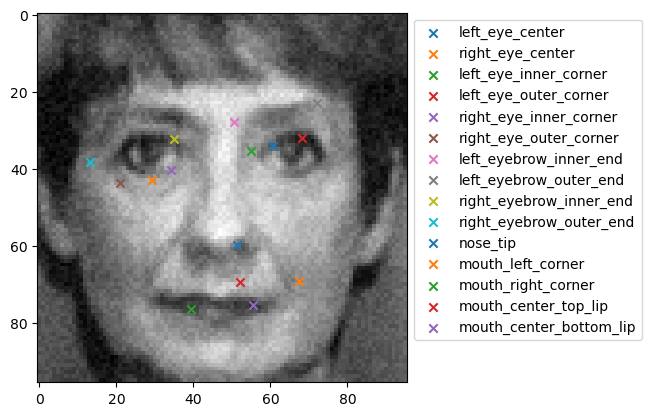

In [80]:
# view first exmaple with labels
plt.imshow(X_test_torch[0].reshape((96,96)), cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(test_pred[0,2*n]
                ,test_pred[0,2*n+1]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

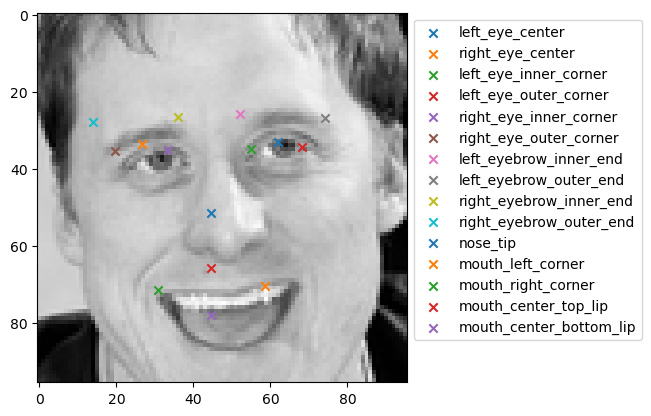

In [81]:
# view second exmaple with labels
plt.imshow(X_test_torch[1].reshape((96,96)), cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(test_pred[1,2*n]
                ,test_pred[1,2*n+1]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

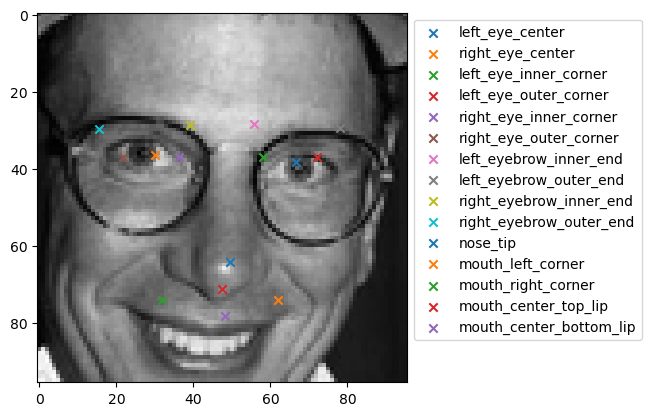

In [82]:
# view third exmaple with labels
plt.imshow(X_test_torch[2].reshape((96,96)), cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(test_pred[2,2*n]
                ,test_pred[2,2*n+1]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

* Another clear benefit of this method is it is now able to also learn the relationship between features
* i.e. that the eye features are usually close and aligned along the x axis
* This is something the previous method was not able to do
* This explains predictions where the features are in the correct orientation, but slightly misaligned
* Need to be caredul it's not just predicting the average points for each

# Make predictions of Final Test set and submit

In [83]:
# create image array
n_examples = test.shape[0]

test_image_flat = np.array([x.split() for x in test['Image'].values])
X_test_Final = np.array(test_image_flat).astype(float).reshape(n_examples,96,96)

# standardise between 1 and 0
X_test_Final /= pixel_max

In [84]:
X_torch_test_final = torch.tensor(X_test_Final, dtype=torch.float32).view([len(X_test_Final), 1, 96, 96])

In [85]:
pred_test_final = cnn(X_torch_test_final).detach().reshape(-1)

In [86]:
pred_test_final.shape

torch.Size([53490])

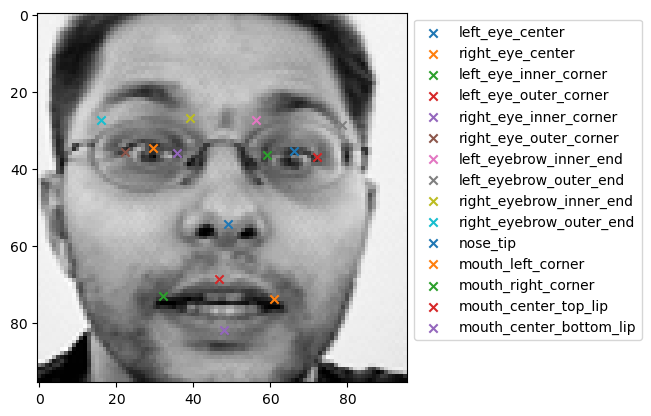

In [87]:
# view first exmaple with labels
plt.imshow(X_torch_test_final[0].reshape((96,96)), cmap='gray')
for n, name in enumerate(feature_names):
    plt.scatter(pred_test_final[2*n]
                ,pred_test_final[2*n+1]
                ,marker='x'
                ,label=name)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

In [88]:
## create array corresponding to feature label
FeatureName = np.tile(raw_fearure_names, (len(X_torch_test_final),1)).reshape(-1)
ImageId = np.arange(1,len(X_torch_test_final)+1).repeat(30)

In [89]:
pred_test_final_df = pd.DataFrame({'ImageId': ImageId
                                  ,'FeatureName': FeatureName
                                  ,'Location': pred_test_final})

In [90]:
pred_test_final_df

ImageId                FeatureName   Location
0            1          left_eye_center_x  66.134956
1            1          left_eye_center_y  35.532249
2            1         right_eye_center_x  29.602512
3            1         right_eye_center_y  34.599434
4            1    left_eye_inner_corner_x  59.028908
...        ...                        ...        ...
53485     1783       mouth_right_corner_y  76.422920
53486     1783     mouth_center_top_lip_x  47.134529
53487     1783     mouth_center_top_lip_y  72.725525
53488     1783  mouth_center_bottom_lip_x  47.360142
53489     1783  mouth_center_bottom_lip_y  81.123138

[53490 rows x 3 columns]

In [91]:
 submission = id_lookup_table.merge(pred_test_final_df, on=['ImageId','FeatureName'], suffixes=['_lookup',None])[['RowId', 'Location']]

In [92]:
print(submission['Location'].min())
print(submission['Location'].max())

11.827946
86.59618


In [93]:
# set feature above threhold of 96 to 96 
threhold_mask = submission['Location'] > 96
submission.loc[threhold_mask, 'Location'] = 96

In [94]:
submission.to_csv('face_key_detection_submission.csv',index = False)